# **LIBRARIES**

In [881]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import scipy.io
import plotly.graph_objects as go
import plotly.offline as pyo
import mat73
import datetime
from scipy.signal import convolve2d
from skimage.measure import block_reduce
import copy

# **LOAD MAP**

In [882]:
#=========METHOD FOR READING A .MAT MATLAB MAP
#mat = scipy.io.loadmat('MyMap.mat')
#raw_map =mat["map"]
#Map = np.array(raw_map, dtype=int)
#map_matrix = Map.reshape((Map.shape[0],Map.shape[1], 1))

In [883]:
#==========METHOD FOR READING PROCESSED NUMPY MAPS
map_matrix = np.load("map_12_12_mean.npy")
print(map_matrix.shape)


(571, 758, 1)


In [884]:
max_x = map_matrix.shape[0]-1
max_y = map_matrix.shape[1]-1

min_x = 0
min_y = 0

# **HYPER-PARAMETERS**

In [885]:
init_point = np.array([490,555],dtype=int)
destination_point  = np.array([340,216],dtype=int)
number_of_max_genes = 32
number_of_initial_genes = 16
number_of_chromosoms = 1024
#penalty constant
P = 1
elitism_rate = 0.01
cross_over_rate = 0.50
mutation_rate = 0.90
#alpha and alpha-1 for c_length and c_altitude
alpha = 0.3

#mutation beta factor
generation_count = 100
parents_generating_factor = 2048

In [886]:
Z_min,Z_max =np.min(map_matrix),np.max(map_matrix)
LP1P2 = np.linalg.norm(init_point - destination_point)
generation_produced=0

# **INITIAL-POPULATION**

In [ ]:
initial_population = []
for i in range(number_of_chromosoms):
  a = np.zeros((number_of_max_genes,1),dtype=int)
  b = np.zeros((number_of_max_genes,1),dtype=int)
  #reserved for length of gene
  a[number_of_max_genes-1]=number_of_initial_genes
  b[number_of_max_genes-1]=number_of_initial_genes
  ran_a = np.random.randint(low=min_x, high=max_x, size=(number_of_initial_genes, 1),dtype=int)
  ran_b = np.random.randint(low=min_y, high=max_y, size=(number_of_initial_genes, 1),dtype=int)
  a[:number_of_initial_genes] = ran_a + a[:number_of_initial_genes]
  b[:number_of_initial_genes] = ran_b + b[:number_of_initial_genes]
  array = np.concatenate((a,b), axis=1,dtype=int)
  initial_population.append(array)
population=initial_population
print(population)

# **FITNESS**

## **3 COST OF OBJECTIVES**

### C(length)

In [888]:

def C_length(chromosome):
  #calculate L(trajectory)
  L_traj = 0
  L_traj += np.linalg.norm(chromosome[0] - init_point)
  #print(len(chromosome))
  for i in range(chromosome[number_of_max_genes-1][0] -1):
    L_traj += np.linalg.norm(chromosome[i+1] - chromosome[i])
  L_traj += np.linalg.norm(destination_point - chromosome[chromosome[number_of_max_genes-1][0]-1])
  cost_length = 1-(LP1P2/L_traj)
  return cost_length

### **C(altitude)**

In [889]:
def Calculate_line_heights(x1,y1,x2,y2):
  squares = myraytrace(x1,y1,x2,y2)
  sum=0
  for square in squares :
      sum += map_matrix[square]
  return sum,len(squares)

In [890]:
def C_altitude(chromosome,Z_min,Z_max):
  total_height=0
  num_squares=0
  val,c = Calculate_line_heights(init_point[0],init_point[1],chromosome[0][0],chromosome[0][1])
  total_height +=val
  num_squares += c
  for i,point in enumerate(chromosome) :
    if(i<=chromosome[number_of_max_genes-1][0]-1):
      val,c = Calculate_line_heights(chromosome[i][0],chromosome[i][1],chromosome[i+1][0],chromosome[i+1][1])
      total_height +=val
      num_squares += c
  val,c = Calculate_line_heights(chromosome[chromosome[number_of_max_genes-1][0]-1][0],chromosome[chromosome[number_of_max_genes-1][0]-1][1],destination_point[0],destination_point[1])
  total_height +=val
  num_squares += c
  A_traj = total_height/num_squares
  C_altitude = (A_traj-Z_min)/(Z_max-Z_min)
  return C_altitude

In [891]:
def myraytrace (i1,j1,i2,j2):
    points = []
    di=(i2-i1)
    dj=(j2-j1)
    if di==0 and dj==0:
        points.append((i1,j1))
        return points
    elif di==0:
        for k in range(min(j1,j2),max(j1,j2)+1):
            points.append((i1,k))
        return points

    elif dj==0:
        for k in range(min(i1,i2),max(i1,i2)+1):
            points.append((k,j1))
        return points

    if abs(di/dj)==1:
        if i1<=i2 and j1<=j2:
            for k in range(i1,i2+1):
                points.append((k,j1+(k-i1)))
        if i1<i2 and j1>j2:
            for k in range(i1,i2+1):
                points.append((k,j1-((k-i1))))
        if i1>i2 and j1<j2:
            for k in range(i2,i1+1):
                points.append((k,j2-((k-i2))))
        if i1>i2 and j1>j2:
            for k in range(i2,i1+1):
                points.append((k,j2+((k-i2))))
        return points

    points.append((i1,j1))

    switch=0
    if dj!=0 and abs(di/dj)>1:

        i1,j1,i2,j2=j1,i1,j2,i2
        switch=1
    if np.sqrt((i1*i1+j1*j1))>np.sqrt((i2*i2+j2*j2)):
        #switch=1
        i1,j1,i2,j2=i2,j2,i1,j1

    di=(i2-i1)
    dj=(j2-j1)
    tangteta=di/dj
    if dj!=0 and di!=0 and abs(di/dj)!=1:
        for k in range(0,j2-j1,1):
            mini=i1+1/2 +((k+1/2)*tangteta)
            maxi=i1+1/2 +((k+3/2)*tangteta)
            minj=j1+1+k
            if int(mini)==int(maxi):
                if switch==0:
                    points.append((int(mini),minj))
                else:
                    points.append((minj,int(mini)))
            else:
                if switch==0:
                    points.append((int(mini),minj))
                    points.append((int(maxi),minj))
                else:
                    points.append((minj,int(mini)))
                    points.append((minj,int(maxi)))

    return points


### **C(Fuel)**

In [892]:

def C_fuel(chromosome,FP1P2,F_init):
  return 0

##تعیین تابع شایستگی بر اساس هزینه ها

In [893]:
def Fitness(chromosome):
  c = (alpha*C_length(chromosome)) + ((1-alpha)*C_altitude(chromosome,Z_min,Z_max)) #+ C_fuel()
  f = 1/c
  return f

# **PARENT-SELECTION**

In [894]:
def stochastic_universal_sampling(population_fitness, num_parents):

    F = sum(population_fitness) # calculate the sum of fitness values
    N = num_parents
    P = F / float(N) # calculate the spacing between selection points
    start_point = np.random.uniform(0, P) # choose a random starting point within the spacing

    parents = []
    cumulative_fitness = population_fitness[0]
    parent_idx = 0

    for i in range(N):
        while start_point > cumulative_fitness:
            parent_idx += 1
            cumulative_fitness += population_fitness[parent_idx]
        parents.append(parent_idx)
        start_point += P

    return parents

In [895]:
def Parent_Selection(parents_count):
  fitness = np.zeros((number_of_chromosoms,parents_count))
  for i in range(number_of_chromosoms):
    fitness[i][1] = Fitness(population[i])
    fitness[i][0] = i
  column_to_sort = fitness[:, 1]  # Extract the specific column to sort
  sorted_indices = np.argsort(column_to_sort)
  sorted_array_descending = fitness[sorted_indices][::-1]
  fitness_ranked = sorted_array_descending[:,1]
  fitness_index= np.array(stochastic_universal_sampling(fitness_ranked,parents_count),dtype=int)
  p = sorted_array_descending[fitness_index]
  p=p[:,0]
  #returns index of parents in population
  return p.astype(int)

# **CROSS OVER**

## **SINGLE-POINT CROSSOVER**

In [896]:
def Cross_Over(parents_index):
  parent1_index = parents_index[0]
  parent2_index = parents_index[1]
  chromosome1 = population[parent1_index]
  chromosome2 = population[parent2_index]
  child1 = np.zeros((number_of_max_genes,2),dtype=int)
  child2 = np.zeros((number_of_max_genes,2),dtype=int)
  if(chromosome1[number_of_max_genes-1][0]<=chromosome2[number_of_max_genes-1][0]):
    slice_point = np.random.randint(0,chromosome1[-1][0])
    child1[number_of_max_genes-1][0]=chromosome2[number_of_max_genes-1][0]
    child2[number_of_max_genes-1][0]=chromosome2[number_of_max_genes-1][0]
  else:
    slice_point = np.random.randint(0,chromosome2[-1][0])
    child1[number_of_max_genes-1][0]=chromosome1[number_of_max_genes-1][0]
    child2[number_of_max_genes-1][0]=chromosome1[number_of_max_genes-1][0]


  child1[:slice_point,:] = chromosome1[:slice_point,:]
  child1[slice_point:chromosome2[-1][0],:] = chromosome2[slice_point:chromosome2[-1][0],:]

  child2[:slice_point,:] = chromosome2[:slice_point,:]
  child2[slice_point:chromosome1[-1][0],:] = chromosome1[slice_point:chromosome1[-1][0],:]

  # print(chromosome1,chromosome2,child1,child2)
  # print(len(chromosome1),len(chromosome2),len(child1),len(child2))
  return child1,child2

# **MUTATION**

## **1-Modification**

In [897]:
def Modification_Mutation(chromosome):
  modify_point = np.random.randint(0,chromosome[number_of_max_genes-1][0])
  #find neighberhoods of the point
  x_lim1 =0
  x_lim2 =0
  y_lim1 =0
  y_lim2 =0
  if(modify_point==0):
    x_lim1 = init_point[0]
    x_lim2 = chromosome[modify_point+1,:][0]
    y_lim1 = init_point[1]
    y_lim2 = chromosome[modify_point+1,:][1]

  elif(modify_point != chromosome[number_of_max_genes-1][0]-1):
    x_lim1 = chromosome[modify_point-1,:][0]
    x_lim2 = chromosome[modify_point+1,:][0]
    y_lim1 = chromosome[modify_point-1,:][1]
    y_lim2 = chromosome[modify_point+1,:][1]

  else:
    x_lim1 = chromosome[modify_point-1,:][0]
    x_lim2 = destination_point[0]
    y_lim1 = chromosome[modify_point-1,:][1]
    y_lim2 = destination_point[1]

  if(x_lim1>x_lim2):
       t = x_lim2
       x_lim2 = x_lim1
       x_lim1 = t
  if(y_lim1>y_lim2):
      t = y_lim2
      y_lim2 = y_lim1
      y_lim1 = t
  if((x_lim1==x_lim2) or (y_lim1==y_lim2)):
    return chromosome
  neighberhood_x = np.random.randint(x_lim1,x_lim2)
  neighberhood_y = np.random.randint(y_lim1,y_lim2)
  chromosome[modify_point,:][0]=neighberhood_x
  chromosome[modify_point,:][1]=neighberhood_y
  return chromosome

## **2-ADDITION**

In [898]:
def Addition_Mutation(chromosome):
  if(chromosome[number_of_max_genes-1][0]<=number_of_max_genes-2):
    Added_point_place = np.random.randint(0,chromosome[number_of_max_genes-1][0])
    point_x = np.random.randint(0,max_x);
    point_y = np.random.randint(0,max_y);
    adding_point = np.array([point_x, point_y],dtype=int)
    #add init point into chromosome
    new_chromosome = np.insert(chromosome, Added_point_place, adding_point,axis=0)
    new_array = np.delete(new_chromosome, number_of_max_genes-1, axis=0)
    new_array[number_of_max_genes-1][0] +=1
    return new_array
  else:
    return chromosome
  #update number_of_current_genes +=1

## **3-DELETION**

In [899]:
def Deletion_Mutation(chromosome):
  if(chromosome[(number_of_max_genes-1)][0]>1):
      Delete_point_place = np.random.randint(0,chromosome[number_of_max_genes-1][0])
      new_array = np.delete(chromosome, Delete_point_place, axis=0)
      new_array = np.append(new_array, [np.array([0, 0],dtype=int)], axis=0)
      new_array[number_of_max_genes-1]=new_array[number_of_max_genes-2]
      new_array[number_of_max_genes-2]=[0,0]
      new_array[number_of_max_genes-1][0] -=1
      #print(type(new_array))
      return new_array
  else:
    return chromosome

## **Mutation**


In [900]:
def Mutation(chromosome):
   selector= np.random.randint(1,4)
   Mutated = chromosome
   if(selector==1):
    Mutated=Modification_Mutation(chromosome)
   elif(selector==2):
    Mutated=Addition_Mutation(chromosome)
   elif(selector==3):
    Mutated=Deletion_Mutation(chromosome)
   return Mutated

# **REPLACEMENT**

In [901]:
def Replacement(old_population,offspring_generation,NSGA2=False):
  if(NSGA2==True):
    
    sended_list =old_population+offspring_generation
    #print("Sended list : ",len(sended_list))
    selected_list = NSGA_2(sended_list)
    #print("Received list : ",len(selected_list))
    selected_elements_new_generations = [sended_list[k] for k in selected_list]
    #print("Returned list : ",len(selected_elements_new_generations))
    return selected_elements_new_generations
  else:
    final_population = []
    pop_old = []
  # SELECT ELITES FROM OLD POPULATION
    fitness = np.zeros((len(old_population),2))
    for i in range(len(old_population)):
      fitness[i][1] = Fitness(old_population[i])
      fitness[i][0] = i
    column_to_sort = fitness[:, 1]  # Extract the specific column to sort
    sorted_indices = np.argsort(column_to_sort)
    fitness_ranked = fitness[sorted_indices][::-1]
    elite_count = int(elitism_rate*len(old_population))
    for i in range(elite_count):
      pop_old.append((old_population[int(fitness_ranked[i][0])]))
    #print("part1 ended")
    #print(type(old_population),len(old_population))
    #print(type(offspring_generation),len(offspring_generation))
  # ===========================================================================
  # SELECT OFF-SPRINGS
    offsprings_count = number_of_chromosoms-elite_count
    #print(number_of_chromosoms,elite_count)
    fitness_new = np.zeros((len(offspring_generation),2))
    for j in range(len(offspring_generation)):
      fitness_new[j][1] = Fitness(offspring_generation[j])
      fitness_new[j][0] = j
    column_to_sort_new = fitness_new[:, 1]  # Extract the specific column to sort
    sorted_indices_new = np.argsort(column_to_sort_new)
    fitness_ranked_new = fitness_new[sorted_indices_new][::-1]
    pop_new= np.array(stochastic_universal_sampling(fitness_ranked_new[:,1],offsprings_count),dtype=int)
    pop_new2 = fitness_ranked_new[pop_new]
    pop_new2 = pop_new2[:,0].astype(int)
    selected_elements_new_generations = [offspring_generation[k] for k in pop_new2]
    return pop_old+selected_elements_new_generations

# **NSGA II**

In [902]:
def NSGA_2(mixed_population):
    #each cell is a number that specify domination count of an individual
    Domination_counts  = [0 for i in range(len(mixed_population))]
    #each cell is a list of numbers that specify dominated individuals indexes of an individual
    #outer array
    dominated_list = []
    new_population = []
    #calculate each chromosome f1,f2 fitnesses
    costs = np.zeros((len(mixed_population),3))
    for j in range(len(mixed_population)):
        costs[j][1] =   C_length(mixed_population[j])
        costs[j][2] = C_altitude(mixed_population[j],Z_min,Z_max)
        costs[j][0] = j
    #iterate through mixed population to find domination_counts and lists of dominatings
    #A(x1|y1) dominates B(x2|y2) if : ((x1<=x2 and y1<=y2) and (x1<x2 or y1<y2))
    #x1: costs[i][1]
    #x2: costs[j][1]
    #y1: costs[i][2]
    #y2: costs[j][2]

    for i in range(len(mixed_population)):
        current_list = []
        for j in range(len(mixed_population)):
            if((costs[i][1]<=costs[j][1] and costs[i][2]<=costs[j][2]) and ((costs[i][1]<costs[j][1]) or(costs[i][2]<costs[j][2]))):
                # A dominated B ==> List of A should update and add (B) ALSO Domination_counts[j] +=1
                # inner array
                current_list.append(j)
                Domination_counts[j] +=1

        #here is the end of loop for each chromosome ==> list of the dominations of the chromosome should append to dominated_list

        dominated_list.append(copy.deepcopy(current_list))
        current_list.clear()
    # at the end of this double for loops we should have all the dominated list and dominated-by counts
    # so it's time to do F1,F2,F3 FRONT selecting
    #===============================================
    #print("Dominated List: ",dominated_list)
    # non_dominated_indices = np.where(np.array(Domination_counts) == 0)[0]
    # Domination_counts2 = copy.deepcopy(Domination_counts)
    # Domination_counts2 = np.array(Domination_counts2)
    # Domination_counts2[non_dominated_indices] -=1

    Fronts_list = []
    selected_list =[]
    # add a new column of indices to the array
    #===================F1
    next_front = []
    # non_dominated_indices = np.where(np.array(Domination_counts) == 0)[0]
    # Domination_counts[Domination_counts==0] = -1
    # Fronts_list.append(non_dominated_indices)
    # next_front.append(non_dominated_indices)
    
    for i in range(len(mixed_population)):
         if(Domination_counts[i]==0):
             Domination_counts[i] =-1
             #STEP 1 - APPEND TO SELECTED POPULATION
             selected_list.append(i)
             #STEP 2 - SET ID IN POPULATION AND RANK=1 TO id_F_ranks[i]
             #STEP 3 - APPEND TO next_front TO USE THIS LIST FOR NEXT FRONT ITERATION
             next_front.append(i)
             #ranks_list[i]=1
    #print("Domination count : ",Domination_counts)
    #print("next front",next_front)
    #print(type(dominated_list[1]))
    #===================F2,F3,F4,F5,...
    switch=True
    front_rank = 1
    next_front2=copy.deepcopy(next_front)
    counter=len(next_front2);


    while(counter<len(mixed_population)):
        #print(counter)
        front_rank +=1
        next_front_temporary = []
        # STEP ONE : ITERATE THROUGH INDIVIDUALS IN PREVIOUS FRONT()
        for i in (next_front2):
            #STEP ONE-1 : ITERATE THROUGH EACH PREVIOUS FRONT INDIVIDUAL LIST TO DECREASE (-1) Domination_counts THAT AFFECTED BY THEM
            for index in dominated_list[i]:
                #print(f"index{i}",index)
                #STEP ONE-2 : DECREASE THE domination_count of the individual that increased by one because of previous Front individual i
                Domination_counts[index] -=1
        #STEP TWO : ITERATE THROUGH ALL REMAINED INDIVIDUALS TO FIND WHICH ONE HAVE domination_cont=0
        for i in range(len(mixed_population)):
            #STEP TWO-1 : CHECK THAT INDIVIDUAL CAN PLACED TO CURRENT FRONT OR NOT ?
            if(Domination_counts[i]== 0):
                Domination_counts[i]=-1
                selected_list.append(i)
                #ranks_list[i]=front_rank
                counter +=1
                #STEP TWO-3 APPEND TO next_front TO USE THIS LIST FOR NEXT FRONT ITERATION
                next_front_temporary.append(i)

        #STEP THREE : CLEAR next_front and assign next_front_temp to it for next iteration
        #if next_front_temp is empty so all pareto soloutions are finded and we can find them anymore
        #if(len(next_front_temporary)==0):
        
        #print("Domination Count : ",Domination_counts)
        #print("selected list: ",selected_list)
        #print("count: ",counter)
        #print(f"front{front_rank}",next_front)
        Fronts_list.append(copy.deepcopy(next_front2))
        next_front2.clear()
        next_front2=next_front_temporary
    #print(Fronts_list)
#===================================================================================================================
#NOW WE SHOULD CALCULATE CROWDING DISTANCE FOR EACH INDIVIDUAL
    infinity = 1e+14
    added_population = 0
    #print(Fronts_list)
    #FOR EACH FRONT WE SHOULD DO CALCULATIONS: 
    for front in Fronts_list:
        if(len(front)+added_population<=number_of_chromosoms):
             #NO-NEED CROWDING DISTANCE : ADD DIRECTLY THIS FRONT TO NEW POPULATION
             new_population.extend(front)
             added_population +=len(front)
            
        else:
            #NEED CROWDING DISTANCES TO CHOOSE BETTER ANSWERS
            #print(front)
            #print("+++++++++++++++++")
            front_length= len(front)
            needed_pop_count =  number_of_chromosoms-added_population
            d1_index = np.zeros((front_length,2))
            d2_index = np.zeros((front_length,2))
            index_f1 =  costs[front][:, :2]
            index_f2 =  costs[front][:, [0, 2]]

            #sort by f1 :index_f1 and f2 : index_f2
            index_f1 = index_f1[index_f1[:, 1].argsort()]
            index_f2 = index_f2[index_f2[:, 1].argsort()]  
            #print(index_f1)  
            #print(index_f2)  
            #FOR EACH OBJECTIVE(f1,f2) WE SHOULD CALCULATE RELATED DISTANCE
            #f1:
            
            val_min= index_f1[0]
            val_max= index_f1[front_length-1]
            d1_index[0][0] = val_min[0]
            d1_index[0][1] = infinity
            d1_index[front_length-1][0] = val_max[0]
            d1_index[front_length-1][1] = infinity
            for i in range(1,front_length-1):
                    d1_index[i][0]=index_f1[i][0]
                    d1_index[i][1]= (abs(index_f1[i+1][1]-index_f1[i-1][1]))/abs(val_max[1]-val_min[1])
            

            #f2:
            val_min2= index_f2[0]
            val_max2= index_f2[front_length-1]
            #print(val_max2)
            #print(val_max2,val_min2)
            d2_index[0][0] = val_min2[0]
            d2_index[0][1] = infinity
            d2_index[front_length-1][0] = val_max2[0]
            d2_index[front_length-1][1] = infinity
            for i in range(1,front_length-1):
                    d2_index[i][0]=index_f2[i][0]
                    d2_index[i][1]= (abs(index_f2[i+1][1]-index_f2[i-1][1]))/abs(val_max2[1]-val_min2[1])
                    #print(abs(index_f2[i+1][1]-index_f2[i-1][1]))
            #print(d1_index)
            #print(d2_index)
            #NOW D1+D2 = CROWDED DISTANCE ==> WE SHOULD SUM UP D1 AND D2 IN ORDER TO HAVE CROWDING DISTANCE OF EACH INDIVIDUAL
            d1_index = d1_index[np.argsort(d1_index[:, 0])]
            d2_index = d2_index[np.argsort(d2_index[:, 0])]
            sum_array = d1_index.copy()
            sum_array[:, 1] += d2_index[:, 1]
            #sort sum_array by crwoding distance descending 
            sorted_array = sum_array[sum_array[:, 1].argsort()[::-1]]
            #CHECK WETHER OUR FRONT LEN IS GREATHER THAN OUR NEEDED POPULATION OR NOT ?
            #IF GREATER ==> USE TORNAUMENT SELECTION 
            #IF LESS THAN OR EQUAL ==> APPEND CURRENT FRONT POPULATION TO NEXT GENERATION 
            selected2 = []
            for i in range (needed_pop_count):
                #print(int(sorted_array[i][0]))
                #print(len(new_population))
                selected2.append(int(sorted_array[i][0]))
            new_population.extend(selected2)
            break
    return new_population

In [903]:
#print(len(NSGA_2(population,population)))
#print((population[0:10]+population[0:10])[10],((population[0:10]+population[0:10]))[11],((population[0:10]+population[0:10]))[9],((population[0:10]+population[0:10]))[19])

# **TRAIN**

## **Generation Handler**

In [904]:
def generation_Handler(generation_produced):
  parents = Parent_Selection(parents_generating_factor)
  offsprings = []
  mutation_chance_factor = (1-(generation_produced/generation_count))
  for i,parent in enumerate(parents):
    current_childs=[]
    if(i>=len(parents)-1):
      break
  #CROSS-OVER
    cross_over_chance = np.random.random()
    if(cross_over_chance<=cross_over_rate):
      current_childs = list((Cross_Over((parents[i],parents[i+1]))))
    else:
      current_childs = list((population[parents[i]],population[parents[i+1]]))
  #MUTATION
    #print(type(current_childs))
    for i in range (len(current_childs)):
      mutation_chance = np.random.random()
      #mutation for child1
      if(mutation_chance<=mutation_rate*mutation_chance_factor):
        current_childs[i] = Mutation(current_childs[i])
    #print(current_childs)
    offsprings.append(current_childs[i])
  new_gen = Replacement(population,offsprings,NSGA2=True)
  return new_gen

## Traning Loop

In [905]:
population = initial_population
generation_produced = 0
for i in range (generation_count):
  population = generation_Handler(generation_produced)
  generation_produced +=1
trained_population=population

In [907]:
s = []
for  i,child in enumerate(trained_population):
    s.append([Fitness(child),i])
s=sorted(s)[::-1]
print(s)

[[array([3.49929567]), 632], [array([3.49918816]), 686], [array([3.49918816]), 439], [array([3.49833196]), 751], [array([3.49833196]), 180], [array([3.49788624]), 931], [array([3.49778879]), 944], [array([3.49778879]), 842], [array([3.49778879]), 494], [array([3.49660776]), 752], [array([3.49660776]), 430], [array([3.49593572]), 914], [array([3.49593572]), 622], [array([3.49582364]), 551], [array([3.49582364]), 495], [array([3.49501956]), 901], [array([3.49501956]), 391], [array([3.49432091]), 741], [array([3.49413038]), 602], [array([3.49413038]), 160], [array([3.49260254]), 412], [array([3.49214008]), 538], [array([3.49115276]), 836], [array([3.49115276]), 629], [array([3.48982428]), 962], [array([3.48902023]), 536], [array([3.48902023]), 386], [array([3.48569278]), 690], [array([3.48569278]), 501], [array([3.48444352]), 872], [array([3.48444352]), 701], [array([3.48444352]), 646], [array([3.48439921]), 975], [array([3.48439921]), 161], [array([3.48431255]), 407], [array([3.48429048]

In [929]:
for i,chromosome in enumerate(trained_population):
    print(chromosome[-1][0],i)

22 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
4 14
7 15
1 16
1 17
1 18
2 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
17 28
22 29
1 30
8 31
1 32
1 33
1 34
6 35
5 36
1 37
1 38
3 39
1 40
1 41
1 42
5 43
4 44
1 45
1 46
1 47
2 48
1 49
5 50
1 51
1 52
1 53
1 54
2 55
1 56
1 57
4 58
1 59
1 60
1 61
1 62
1 63
1 64
3 65
2 66
1 67
1 68
2 69
3 70
2 71
1 72
1 73
1 74
1 75
3 76
1 77
3 78
3 79
5 80
1 81
1 82
1 83
4 84
5 85
1 86
1 87
1 88
2 89
1 90
5 91
2 92
1 93
3 94
5 95
1 96
1 97
2 98
5 99
5 100
4 101
5 102
2 103
1 104
2 105
4 106
4 107
17 108
5 109
4 110
5 111
5 112
1 113
1 114
5 115
4 116
3 117
4 118
5 119
5 120
3 121
7 122
4 123
6 124
5 125
5 126
6 127
5 128
1 129
3 130
3 131
3 132
1 133
4 134
4 135
3 136
3 137
1 138
1 139
5 140
4 141
5 142
3 143
3 144
18 145
5 146
20 147
5 148
4 149
16 150
5 151
4 152
1 153
1 154
3 155
4 156
5 157
3 158
2 159
2 160
4 161
6 162
11 163
11 164
8 165
5 166
10 167
13 168
19 169
10 170
12 171
4 172
3 173
3 174
17 175
17 176
4 177
5 178
3 179
4 180
5 181
14

# **VISUALIZATION**

## **Utility Functions**

In [269]:
def Calculate_max_height(x1,y1,x2,y2):
  squares = myraytrace(x1,y1,x2,y2)
  max=0
  for square in squares :
    current=map_matrix[square]
    if(current>=max):
      max=current
  return max

In [270]:
def to_3D(chromosome):
#3d model of chromosome
  new_column = np.zeros((number_of_max_genes+1,1),dtype=int)

#init point -----> chromosome[0]
  new_column[0]=Calculate_max_height(init_point[0],init_point[1],chromosome[0][0],chromosome[0][1])

#chromosoe[0] ----> ... -----> chromosome[chromosome[number_of_max_genes - 1]]  (means last point)
  save_i=0
  for i,point in enumerate(chromosome):
    if(i<=chromosome[number_of_max_genes-1][0]-2):
      new_column[i+1] = Calculate_max_height(chromosome[i][0],chromosome[i][1],chromosome[i+1][0],chromosome[i+1][1])
      save_i = i+2
#chromosome[chromosome[number_of_max_genes - 1]] ----->  Destination_Point
    new_column[save_i] = Calculate_max_height(chromosome[chromosome[number_of_max_genes-1][0]-1][0],chromosome[chromosome[number_of_max_genes-1][0]-1][1],destination_point[0],destination_point[1])
    x=destination_point[0]
    y=destination_point[1]
    new_column[save_i+1] = map_matrix[x][y]

  chromosome = np.insert(chromosome, 0, init_point,axis=0)
  chromosome = np.insert(chromosome,save_i+1,  destination_point,axis=0)
  count=chromosome[-1][0]
  chromosome = np.delete(chromosome, -1, axis=0)
  chromosome[-1][0]=count

  chromosome_3d = np.hstack((chromosome, new_column))

  return chromosome_3d


## **MAPS**

### **NON-INTERACTIVE**

#### **MESH-GRID 3D SURFACE PLOT**

[[ 490  747  925]
 [ 472  716  952]
 [ 287  555  827]
 [ 254  521  845]
 [ 211  500  845]
 [ 164  485  851]
 [ 149  471 1109]
 [ 110  317 1081]
 [ 110  310 1185]
 [ 116  239 1186]
 [ 190  167 1546]
 [ 211  152 1469]
 [ 232  129 1459]
 [ 271   82 1614]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [  12    0    0]]


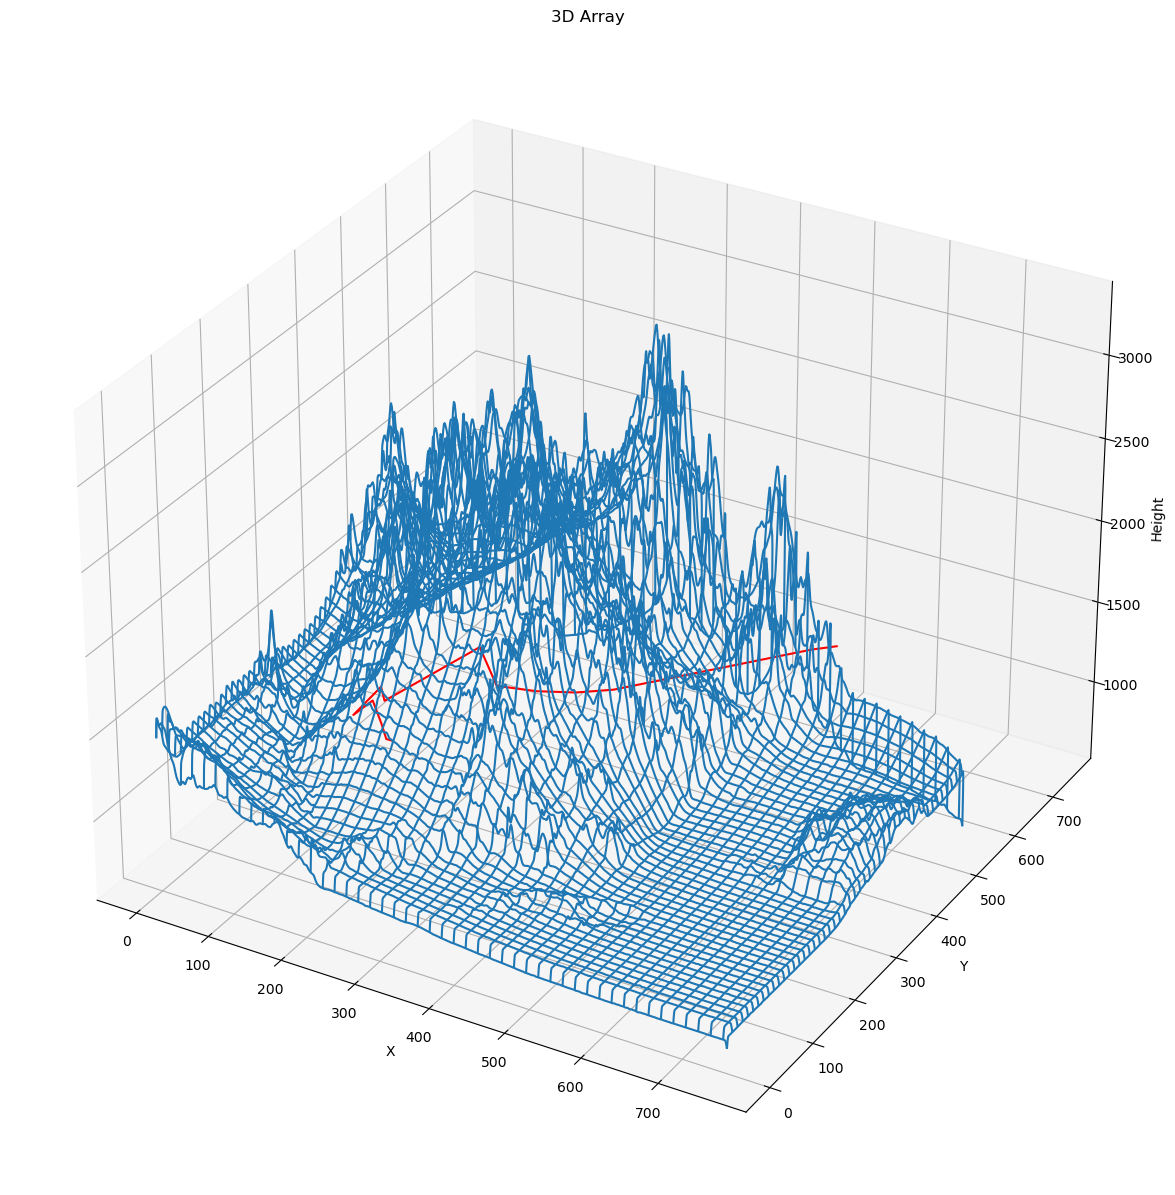

In [393]:


# تولید یک آرایه با شکل (210, 258, 1)
array_3d = map_matrix

# تعیین ابعاد آرایه
size_x, size_y, size_z = array_3d.shape

# ایجاد مشترک x و y
x, y = np.meshgrid(np.arange(size_y), np.arange(size_x))
array_3d=gaussian_filter(array_3d[:,:,0],sigma=1)

# ایجاد شکل سه بعدی
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# رسم نمودار سه بعدی
#ax.plot_surface(x, y, gaussian_filter(array_3d[:,:,0],sigma=1), cmap='viridis')

ax.plot_wireframe(x, y,array_3d , cmap='viridis')

chromosome3d = to_3D(trained_population[101])
print(chromosome3d)
x_line = chromosome3d[:chromosome3d[-1][0]+2,0]
y_line = chromosome3d[:chromosome3d[-1][0]+2,1]
z_line = chromosome3d[:chromosome3d[-1][0]+2,2]
ax.plot(x_line, y_line, z_line, color='red')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# تنظیم برچسب‌ها و عنوان
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title('3D Array')

# نمایش نمودار
plt.show()

#### **PATH 3D  PLOT**

[[ 73 529]
 [242 570]
 [132 522]
 [ 96 506]
 [262 635]
 [ 87 493]
 [ 62 456]
 [298 640]
 [166 628]
 [ 43 608]
 [292 583]
 [ 50 600]
 [ 43 608]
 [ 81 417]
 [ 87 399]
 [198 742]
 [ 76 325]
 [ 75 233]
 [ 90 111]
 [ 99  83]
 [  0   0]
 [  0   0]
 [  0   0]
 [  0   0]
 [ 20   0]]
[[ 490  747  930]
 [ 457  656  920]
 [ 404  655  936]
 [ 380  654  913]
 [ 331  626  844]
 [ 271  584  812]
 [ 271  584  813]
 [ 201  608  795]
 [ 200  591  799]
 [ 153  568  989]
 [  86  304 1073]
 [  72  278 1087]
 [  71  228 1046]
 [  71  215 1476]
 [ 172  209 1476]
 [ 271   82 1614]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [   0    0    0]
 [  14    0    0]]


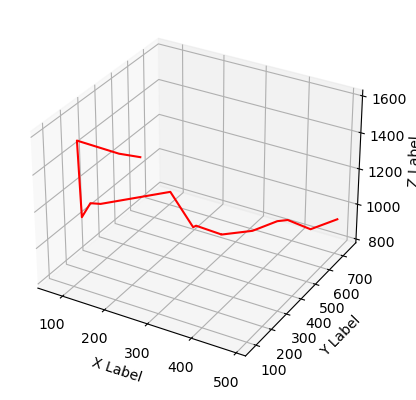

In [360]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(trained_population[1])
chromosome3d = to_3D(trained_population[93])
print(chromosome3d)
x_line = chromosome3d[:chromosome3d[-1][0]+2,0]
y_line = chromosome3d[:chromosome3d[-1][0]+2,1]
z_line = chromosome3d[:chromosome3d[-1][0]+2,2]
ax.plot(x_line, y_line, z_line, color='red')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### **INTERACTIVE PATH AND MAP 3D SURFACE PLOT**

In [935]:

for i in range(len(trained_population)):
    # Create a (208, 256, 1) NumPy array
    chromosome3d = to_3D(trained_population[i])
    # Create the x, y, and z coordinates for the surface plot
    array_3d = map_matrix

    # تعیین ابعاد آرایه
    size_x, size_y, size_z = array_3d.shape

    # ایجاد مشترک x و y
    x, y = np.meshgrid(np.arange(size_y), np.arange(size_x))



    # Create the 3D scatter plot

    surface_trace = go.Surface(x=y, y=x, z=array_3d[:,:,0],opacity=0.95)
    x2 = chromosome3d[:chromosome3d[-1][0]+2,0]
    y2 = chromosome3d[:chromosome3d[-1][0]+2,1]
    z2= chromosome3d[:chromosome3d[-1][0]+2,2]
    line_trace = go.Scatter3d(x=x2, y=y2, z=z2, mode='lines',line=dict(color="green",width=10))

    fig = go.Figure(data=[surface_trace,line_trace])

    # Set the title and axes labels
    fig.update_layout(title='Interactive Surface Plot',
                    scene=dict(xaxis_title='X',
                                yaxis_title='Y',
                                zaxis_title='Z'))
    fig.update_layout(scene=dict(aspectmode='manual',
                                aspectratio=dict(x=4, y=4, z=1)))# Display the plot
    pyo.plot(fig, filename=f"my_plot{i}.html", show_link=False,)

KeyboardInterrupt: 

In [ ]:
79,111,21,120

# **MAP SCALING**

In [ ]:
#THIS IS A FUNCTION FOR READING OLD MATLAB ALTITUDE MAPS AND CONVOLVE THEM TO A SCALED MAP USING 2D MEAN CONVOLUTION
def map_scaling(convolution_frame_x,convolution_frame_y,map_file='kashan-qom.mat',save=False,show=False):
    data_dict = mat73.loadmat(map_file)
    data= np.array(data_dict['map'])
# Define the kernel for convolution
    kernel = np.ones((convolution_frame_x, convolution_frame_y)) / (convolution_frame_x * convolution_frame_y)
# Convolve the data with the kernel
    convolved_data = convolve2d(data, kernel, mode='same', boundary='fill', fillvalue=0)
# Downsample the data using block_reduce with a block size of convolution_frame_x * convolution_frame_y
    downsampled_data= block_reduce(convolved_data, block_size=(convolution_frame_x, convolution_frame_y), func=np.mean)
    downsampled_data = downsampled_data.reshape((downsampled_data.shape[0],downsampled_data.shape[1], 1))
    downsampled_data=downsampled_data.astype(int)
    if save == True:
        now = datetime.datetime.now()
        timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
        np.save(f"map{convolution_frame_x}x{convolution_frame_x}_{timestamp}.npy", downsampled_data)
    if show== True :
        array_3d = downsampled_data
        size_x, size_y, size_z = array_3d.shape
        x, y = np.meshgrid(np.arange(size_y), np.arange(size_x))
        surface_trace = go.Surface(x=y, y=x, z=array_3d[:,:,0])
        fig = go.Figure(data=[surface_trace])
        fig.update_layout(title='Interactive Surface Plot',
                             scene=dict(xaxis_title='X',
                             yaxis_title='Y',
                             zaxis_title='Z'))
        fig.update_layout(scene=dict(aspectmode='manual',
                             aspectratio=dict(x=4, y=4, z=1)))# Display the plot
        pyo.plot(fig, filename='my_plot_temp.html', show_link=False)


In [ ]:
map_scaling(24,24,save=True,show=True)